In [1]:
import config as c
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Descriptive Analysis
- demographic data
- fitts' law
    - effective id
    - task completion time (overall & per id)
    - error rate (overall & per id)
    - throughput (overall & per id)
    - regression of error rate
    - regression of task completion time
- nasa-tlx

## Analysis of Demographic Data

In [17]:
demographic_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    demographic_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/demographic_participant_{id + 1}.csv"
    )
    demographic_df = pd.concat([demographic_df, demographic_raw])

demographic_df.head()

,participant_id,agreed,age,gender,hand,input_device,mouse
0,1,True,23,male,right,Mouse,often
0,2,True,26,female,right,Touchpad,never
0,3,True,25,male,right,Mouse,often
0,4,True,24,male,right,Mouse,often
0,5,True,24,female,right,Touchpad,never


In [18]:
mean_age = np.mean(demographic_df["age"])
std_age = np.std(demographic_df["age"])
print("Average age: ", mean_age, " (Std: ", std_age, ")")
print(
    "Gender: \n",
    demographic_df["gender"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Handedness: \n",
    demographic_df["hand"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Most used input device: \n",
    demographic_df["input_device"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Frequency of mouse input: \n",
    demographic_df["mouse"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)

Average age:  24.5  (Std:  0.9574271077563381 )
Gender: 
    gender  count
0    male      4
1  female      2
Handedness: 
     hand  count
0  right      6
Most used input device: 
   input_device  count
0        Mouse      4
1     Touchpad      2
Frequency of mouse input: 
    mouse  count
0  often      4
1  never      2


## Analyis of Fitts' Law 

In [4]:
clicks_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    for trial in range(c.NUM_TRIALS):
        clicks_raw = pd.read_csv(
            c.FOLDER_PATH
            + str(id + 1)
            + f"/clicks_participant_{id + 1}_trial_{trial}.csv"
        )
        clicks_df = pd.concat([clicks_df, clicks_raw])
    
clicks_df.head()

,id,timestamp_ms,participant_id,trial,level_of_latency,target_number,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,0,1710166191603,1,0,0,0,30,450,959,103,957,107,1,1.787344
1,1,1710166193111,1,0,0,1,30,450,1113,975,1117,968,1,1.508388
2,2,1710166194311,1,0,0,2,30,450,670,208,672,211,1,1.199971
3,3,1710166196228,1,0,0,3,30,450,1349,778,1353,787,1,1.916836
4,4,1710166197495,1,0,0,4,30,450,516,474,519,467,1,1.267135


In [5]:
# drop irrelevant columns
clicks_df = clicks_df.drop(
    ["timestamp_ms", "level_of_latency", "target_number"], axis=1
)
# drop rows of first click in round (no fitts law task)
clicks_df = clicks_df.drop(clicks_df.loc[clicks_df["id"] % 9 == 0].index, axis=0)
clicks_df.reset_index(inplace=True, drop=True)
clicks_df.head()

,id,participant_id,trial,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,30,450,670,208,672,211,1,1.199971
2,3,1,0,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,30,450,516,474,519,467,1,1.267135
4,5,1,0,30,450,1403,474,1409,482,1,1.045496


### Overall Fitts' Law Analysis
- Calculation of id
- Calculation of effective id
- Mean error rate
- Mean completion time
- Mean throughput

In [6]:
# calculation of id
clicks_df["ID"] = np.log2(clicks_df["target_amplitude"] / clicks_df["target_width"] + 1)

In [7]:
# calculation of effective id
num_ids = len(clicks_df["ID"].unique())

clicks_df["distance_from_target"] = np.sqrt(
    (clicks_df["target_x"] - clicks_df["cursor_x"])**2 +
    (clicks_df["target_y"] - clicks_df["cursor_y"])**2
)

effective_id_df = pd.DataFrame({"ID": clicks_df["ID"].unique(), 
                                "sigma": np.zeros(num_ids),
                                "amplitude": np.zeros(num_ids),
                                "width": np.zeros(num_ids)})
for _, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            row["amplitude"] = entry["target_amplitude"]
            row["width"] = entry["target_width"]
            row["sigma"] += entry["distance_from_target"]

effective_id_df["sigma"] /= len(clicks_df)/9
effective_id_df["We"] = 4.133 * effective_id_df["sigma"]
effective_id_df["IDe"] = np.log2(
    effective_id_df["amplitude"] / effective_id_df["We"] + 1
)
effective_id_df.sort_values(by=["ID"])

,ID,sigma,amplitude,width,We,IDe
5,1.000000,32.198907,200.0,200.0,133.078082,1.323587
3,1.392317,44.917568,325.0,200.0,185.644308,1.459778
8,1.415037,26.273462,200.0,120.0,108.588218,1.506815
6,1.700440,45.467754,450.0,200.0,187.918226,1.763267
2,1.890771,31.662447,325.0,120.0,130.860892,1.800560
7,2.247928,28.532752,450.0,120.0,117.925862,2.267822
4,2.938599,9.226566,200.0,30.0,38.133397,2.642643
1,3.564785,9.324391,325.0,30.0,38.537707,3.237762
0,4.000000,10.124243,450.0,30.0,41.843497,3.555124


In [8]:
def calculate_mean_std(arr):
    return round(np.mean(arr), 2), round(np.std(arr), 2)

In [9]:
# calculation of mean and standard deviation of error rate and completion time
print("Mean error rate: ",  calculate_mean_std(1 - clicks_df["success"]))
print("Mean completion time: ",  calculate_mean_std(clicks_df["completion_time"]))

Mean error rate:  (0.06, 0.24)
Mean completion time:  (0.64, 0.26)


In [10]:
# calculation of throughput
throughput_df = pd.DataFrame({"IDe": np.zeros(clicks_df.shape[0]),
                              "completion_time": clicks_df["completion_time"],
                              "error_rate": 1 - clicks_df["success"]})

for index, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            throughput_df.loc[index,"IDe"] = row["IDe"]

throughput_df["throughput"] = throughput_df["IDe"] / throughput_df["completion_time"]
print("Mean throughput: ",  calculate_mean_std(throughput_df["throughput"]))

Mean throughput:  (3.59, 1.02)


In [11]:
# calculation of throughput, error rate, completion time per id
ides = throughput_df["IDe"].unique()
throughput_df_per_id = pd.DataFrame({"IDe": ides,
                                     "mean_throughput": np.zeros(len(ides)),
                                     "std_throughput": np.zeros(len(ides)),
                                     "mean_completion_time": np.zeros(len(ides)),
                                     "std_completion_time": np.zeros(len(ides)),
                                     "mean_error_rate": np.zeros(len(ides)),
                                     "std_error_rate": np.zeros(len(ides))})

for _, entry in throughput_df_per_id.iterrows():
    id = entry["IDe"]
    queried_df = throughput_df.query(f"IDe=={id}")
    throughput = queried_df["throughput"]
    completion_time = queried_df["completion_time"]
    error_rate = queried_df["error_rate"]
    entry["mean_throughput"], entry["std_throughput"] = calculate_mean_std(throughput)
    entry["mean_completion_time"], entry["std_completion_time"] = calculate_mean_std(completion_time)
    entry["mean_error_rate"], entry["std_error_rate"] = calculate_mean_std(error_rate)

throughput_df_per_id["IDe"] = round(throughput_df_per_id["IDe"], 2)
throughput_df_per_id = throughput_df_per_id.sort_values(by=["IDe"])
throughput_df_per_id

,IDe,mean_throughput,std_throughput,mean_completion_time,std_completion_time,mean_error_rate,std_error_rate
5,1.32,3.39,1.15,0.43,0.15,0.01,0.08
3,1.46,3.43,1.03,0.46,0.14,0.03,0.18
8,1.51,3.58,1.19,0.46,0.15,0.03,0.17
6,1.76,3.41,0.96,0.56,0.17,0.04,0.21
2,1.80,3.42,0.97,0.57,0.16,0.05,0.21
7,2.27,3.70,0.88,0.65,0.16,0.05,0.22
4,2.64,3.62,0.92,0.78,0.22,0.09,0.29
1,3.24,3.89,0.96,0.89,0.24,0.09,0.29
0,3.56,3.84,0.89,0.98,0.25,0.14,0.35


## Fitts' Law Regression
- Regression model for error rate
- Regression model for completion time

In [12]:
def model_error_rate(x):
    slope_error_rate, intercept_error_rate, r_error_rate, p, std_err = stats.linregress(
        throughput_df_per_id["IDe"], throughput_df_per_id["mean_error_rate"]
    )
    return slope_error_rate * x + intercept_error_rate
slope_error_rate, intercept_error_rate, r_error_rate, p_error, std_err = stats.linregress(
        throughput_df_per_id["IDe"], throughput_df_per_id["mean_error_rate"]
    )
p_error

4.4931966546221166e-05

In [13]:
def model_completion_time(x):
  slope_completion_time, intercept_completion_time, r_completion_time, p, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
  return slope_completion_time * x + intercept_completion_time
slope_completion_time, intercept_completion_time, r_completion_time, p_time, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
p_error

4.4931966546221166e-05

In [14]:
ide = effective_id_df["IDe"]
completion_time = throughput_df_per_id["mean_completion_time"]
e_completion_time = throughput_df_per_id["std_completion_time"] * 1.96 / np.sqrt(throughput_df_per_id.shape[1])
error_rate = throughput_df_per_id["mean_error_rate"]
e_error_rate = throughput_df_per_id["std_error_rate"] * 1.96 / np.sqrt(throughput_df_per_id.shape[1])

regr_completion_time = list(map(model_completion_time, ide))
regr_error_rate = list(map(model_error_rate, ide))

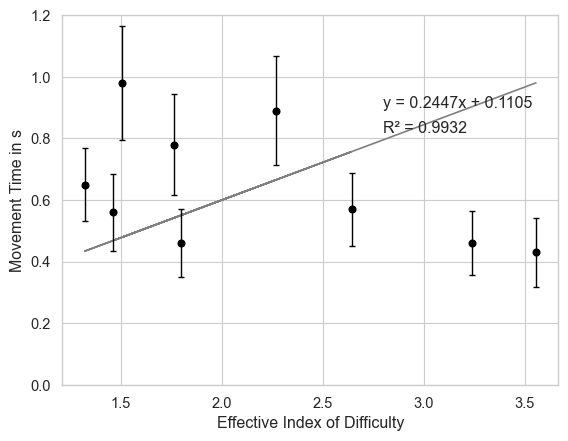

In [15]:
# regression plot for completion time
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_completion_time, color="grey")
plt.errorbar(ide, completion_time, e_completion_time, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Movement Time in s")

plt.ylim(0, 1.2)
plt.text(2.8, 0.82, 'R² = '+ str(round(r_completion_time**2, 4)))
plt.text(2.8, 0.9, 'y = '+ str(round(slope_completion_time, 4)) + "x + " + str(round(intercept_completion_time, 4)))
plt.savefig('figures/regression_completion_time.pdf', bbox_inches='tight')
plt.show()

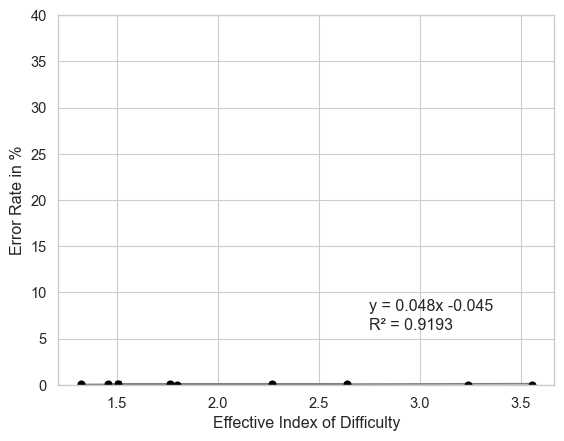

In [16]:
# regression plot for error rate
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_error_rate, color="grey")
plt.errorbar(ide, error_rate, e_error_rate, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Error Rate in %")

plt.ylim(0, 40)
plt.text(2.75, 6, 'R² = '+ str(round(r_error_rate**2, 4)))
plt.text(2.75, 8, 'y = '+ str(round(slope_error_rate, 3)) + "x " + str(round(intercept_error_rate, 3)))
plt.savefig('figures/regression_error_rate.pdf', bbox_inches='tight')
plt.show()